In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:95% !important;}
div.cell.code_cell.rendered{width:95%;}
div.text_cell_render rendered_html{width:95%;}
div.output_wrapper{width:95%;}
div.cell code_cell rendered{width:95%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:14pt;}
div.CodeMirror-scroll { overflow-x: auto; }
div.text_cell_render.rendered_html{font-size:14pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:20px;}
div.output {font-size:14pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:14pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:14pt;padding:5px;}
table.dataframe{font-size:14px;}
</style>
"""))

<font size="5" color="red"><b>ch4. 머신러닝 모형 최적화</b></font>
# 1절. 변수 선택과 차원 축소
## 1-1 변수선택과 차원축소
- 종속변수에 영향을 주는 변수들을 찾아 학습에 사용할 독립변수의 수를 줄임
 (어떻게 하면 score를 높일 수 있을지?)
- 과적합과 변수들 사이의 다중공선성(변수들간 강한 상관관계)을 줄일 수 있음
- 회귀계수 해석이 어려워짐. 모델 예측력이 좋아도 해석력이 떨어짐(어떤 변수가 제일 큰 요인인지 잘), p값이
나 유의성 검정이 왜곡될 수 있음
- 모형의 학습 시간을 줄일 수 있음
- 주성분분석, 상관분석, **분류모형의 feature_importance_, 예측 모형의 coef_**
- SelectKBest : 가장 높은 score에 따라 K개의 특징을 선택

## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 주성분분석은 변수 선택 및 차원축소 방법(기존의 모든 변수를 조합하여 새로운 변수로 만듦) 으로 널리 사용
- 주성분 분석은 상관관계가 있는 변수들을 선형결합해서 **분산이 극대화된 상관관계가 없는 새로운 변수(주성분)
들로 축약**하는 것
- 주성분 분석은 사실 선형대수학이라기보다는 선형대수학의 활용적인 측면이 강하며 영상인식, 통계 데이터분석
(주성분 찾기), 데이터 압축, 노이즈제거 등 여러 분야에 사용
- 영상처리에서 많이 활용 : 여러개의 영상 중 대표 이미지를 찾을 때 활용

In [2]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:,:-1], iris.species
iris_X.shape, iris_y.shape

((150, 4), (150,))

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # n_components: 주성분 갯수
# pca.fit(iris_X)
# pca.transform(iris_X)
iris_pca = pca.fit_transform(iris_X)  # 뽑혀진 pca주성분
iris_pca[:3]   # 뽑혀진 주성분 2개(다중공선성이 없는)

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943]])

In [4]:
# 다중공선성이 없는지 상관계수 확인(상관계수가 높으면 과적합)
import pandas as pd
pd.DataFrame(iris_pca, columns=['pca1','pca2']).corr() # 주성분끼리의 상관관계

,pca1,pca2
pca1,1.000000e+00,3.722081e-16
pca2,3.722081e-16,1.000000e+00


In [5]:
# 설명분산 : 각 주성분이 데이터 분산을 얼마나 잘 표현하는지(정보량)-값이 클수록 더 중요한 주성분
pca.explained_variance_

array([4.22824171, 0.24267075])

In [6]:
# 설명정도 : 0~1사이의 비율로 조정된 값(%로)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [7]:
pca.components_
# 각 주성분의 계수 : 각 주성분이 원래 특성들과 어떤 관계가 있는지 나타내는 가중치
# pca1=0.36138659*sepal_length + -0.08452251*sepal_width + 0.85667061*petal_length + 0.3582892*petal_width
# pca2=0.65658877*sepal_length + 0.73016143*sepal_width + -0.17337266*petal_length + -0.07548102*petal_width

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [8]:
iris_X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 1-3 상관관계 확인
- 각 변수들끼리 상관관계를 확인하고 시각화해서 종속변수와 상관관계가 높은 변수들만 선택

In [9]:
import pandas as pd
# redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine = pd.read_csv('data/winequality-red.csv', delimiter=';')
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- cmap의 종류 : https://jrc-park.tistory.com/155 
- http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap 
- http://seaborn.pydata.org/examples/many_pairwise_correlations.html 

<function matplotlib.pyplot.show(close=None, block=None)>

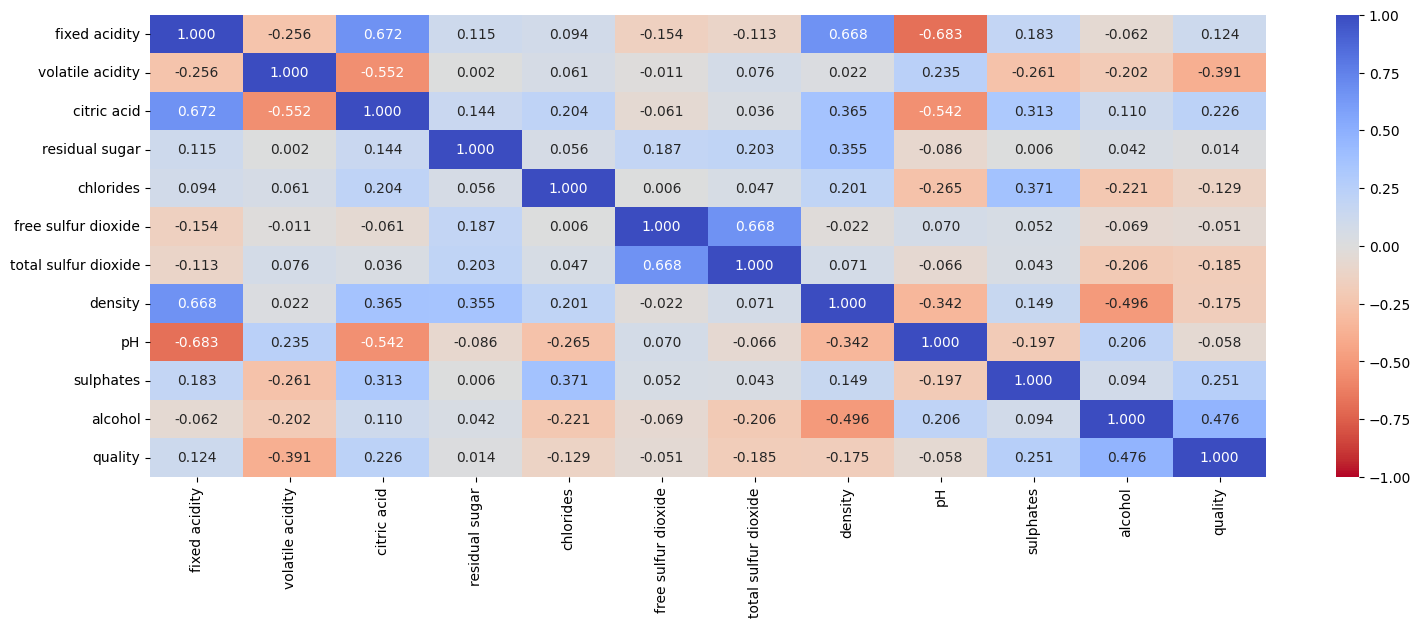

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,6))
corr = redwine.corr()
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r')
plt.show

In [11]:
import numpy as np
mask = np.tril(np.ones_like(corr))  # 대각선 포함하여 아래가 1
mask = np.tril(np.ones_like(corr), k=-1)  # 대각선 제외하고 아래가 1
mask = np.triu(np.ones_like(corr))  # 대각선 포함하여 위가 1
#mask = np.triu(np.ones_like(corr), k=1)  # 대각선 제외하고 위가 1
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

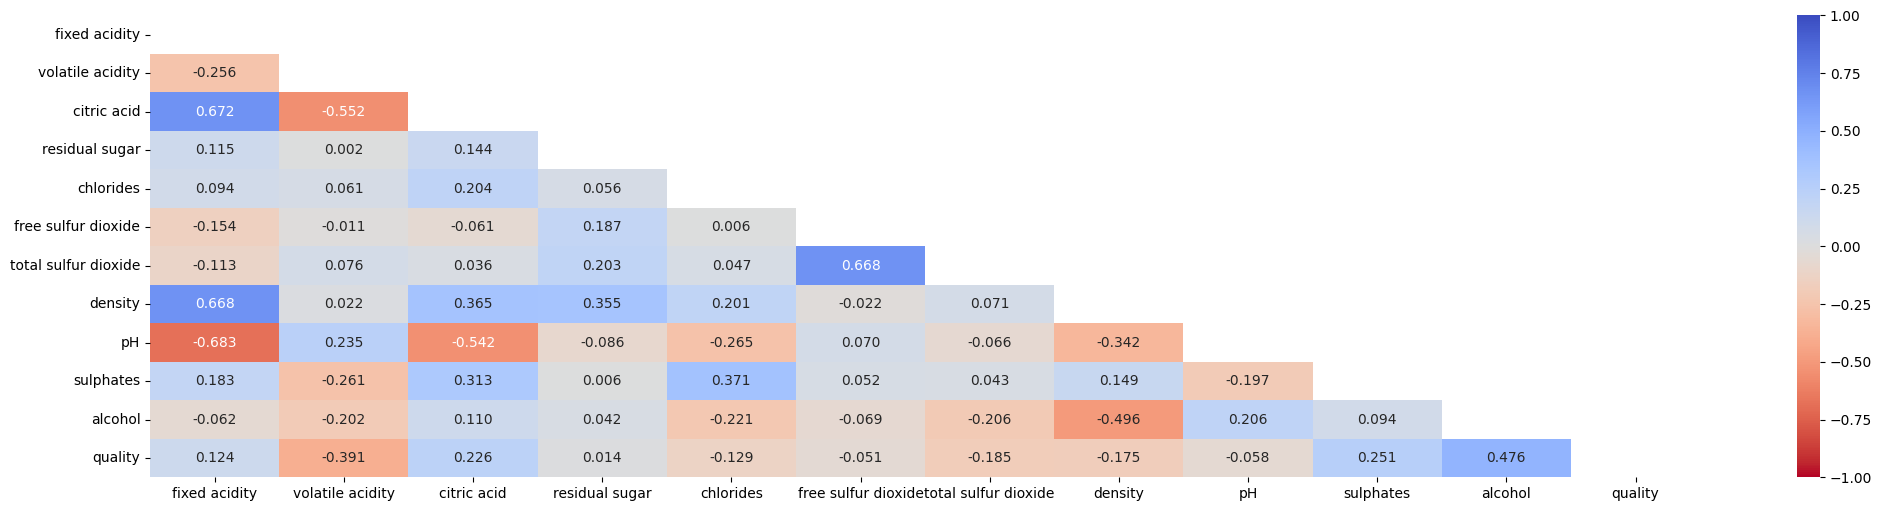

In [12]:
plt.figure(figsize=(25,6))
corr = redwine.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r', mask=mask)
plt.show()

## 1-4 분류모형의 Feature Importance
- 분류모형의 feature_importances_ 속성 : 각 독립변수들이 종속변수에 영향을 주는 정도
- DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier..(tree계열)
- LogisticRegression, SVC, MLPclassifier등은 feature_impotances_ 속성 없음

In [13]:
from sklearn.model_selection import train_test_split
X = redwine.iloc[:, :-1]#.values  # numpy 배열로
y = redwine.iloc[:, -1]#.to_numpy()   # numpy 배열로
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.3, stratify=y)
train_X.shape, test_X.shape, train_y.shape, test_y.shape, type(train_X)

((1119, 11), (480, 11), (1119,), (480,), pandas.core.frame.DataFrame)

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10,  # 트리의 갯수 10  , 복원추출, 병렬처리
                                  random_state=10)
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [15]:
rf_model.score(test_X, test_y)  #accuracy

0.64375

In [16]:
rf_model.feature_importances_  # 종속변수에 영향을 

array([0.06414238, 0.09983185, 0.0850693 , 0.06354534, 0.07631455,
       0.06799421, 0.0997834 , 0.10254206, 0.08001779, 0.09861527,
       0.16214384])

In [17]:
np.c_[X.columns, rf_model.feature_importances_]

array([['fixed acidity', 0.06414237813876575],
       ['volatile acidity', 0.0998318533500041],
       ['citric acid', 0.08506930381665063],
       ['residual sugar', 0.06354534350034054],
       ['chlorides', 0.0763145539511605],
       ['free sulfur dioxide', 0.06799420673549814],
       ['total sulfur dioxide', 0.09978339930161373],
       ['density', 0.10254206252877204],
       ['pH', 0.08001778986371294],
       ['sulphates', 0.09861526635752296],
       ['alcohol', 0.16214384245595867]], dtype=object)

In [18]:
features = pd.DataFrame(np.c_[X.columns, rf_model.feature_importances_],
                        columns=['feature', 'importance'])
features['importance'].sum()

0.9999999999999999

In [19]:
features.sort_values(by='importance', ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features.set_index(drop=True, keys='feature')  # 열이름을 index로 
features

,feature,importance
0,alcohol,0.162144
1,density,0.102542
2,volatile acidity,0.099832
3,total sulfur dioxide,0.099783
4,sulphates,0.098615
5,citric acid,0.085069
6,pH,0.080018
7,chlorides,0.076315
8,free sulfur dioxide,0.067994
9,fixed acidity,0.064142


### feature_importances_를 이용한 변수 중요도 시각화

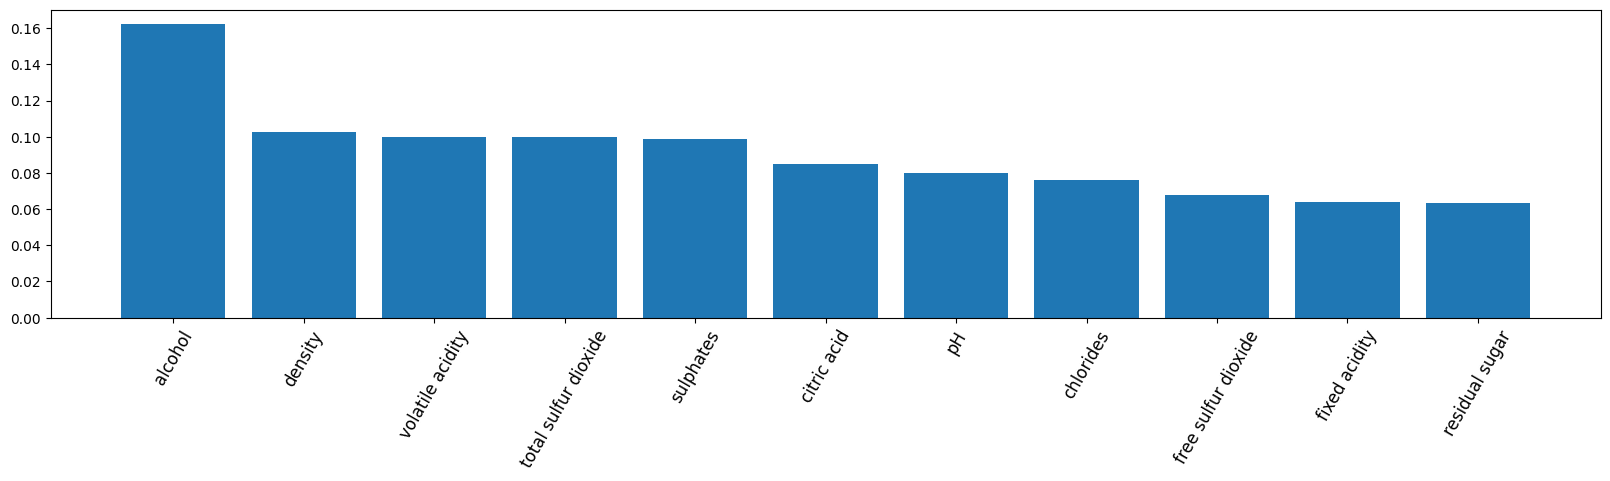

In [20]:
# features를 시각화
plt.figure(figsize=(20,4))
plt.bar(features.feature, features.importance)
plt.xticks(fontsize=12, rotation=60)
plt.show()

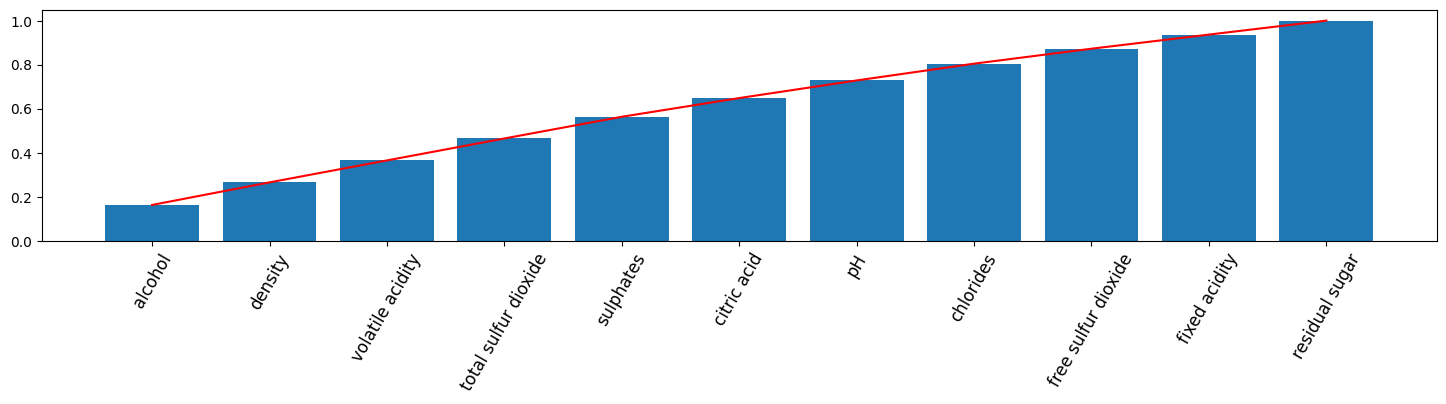

In [21]:
# 누적합을 이용한 시각화
y_stack = np.cumsum(features.importance)
plt.figure(figsize=(18,3))
plt.bar(features.feature, y_stack)
plt.plot(features.feature, y_stack, color='red')
plt.xticks(fontsize=12, rotation=60)
plt.show()

## RFE(Recursive Feature Elimination) 방식(재귀적)
- RFE를 이용하면 중요도에 따라 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택한 변수를 찾는다.

In [22]:
from sklearn.feature_selection import RFE
rfe_model = RFE( #RandomForestClassifier(n_estimators=10,random_state=10)
                rf_model,
                n_features_to_select=5
)
rfe_model.fit(train_X, train_y)
rfe_model.get_support()  # 선택된 변수(True)인지 제거된 변수(False)인지 여부

array([False,  True, False, False, False, False,  True,  True, False,
        True,  True])

In [23]:
feature_rfe = pd.DataFrame(np.c_[X.columns, rfe_model.get_support()],
                          columns=['feature','selected'])
feature_rfe[feature_rfe.selected==True]

,feature,selected
1,volatile acidity,True
6,total sulfur dioxide,True
7,density,True
9,sulphates,True
10,alcohol,True


## 1-5 SelectKBest
- 가장 높은 score에 따라 k개 특징변수 선택

In [24]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, f_classif, chi2
# f_classif : ANNOVA F검정 - 독립변수가 연속형(그룹간 차이가 유의미한지)
# chi2      : 카이제곱통계량 검정 - 독립변수가 범주형(타겟변수도 범주형) 또는 양의 실수
X, y = load_iris(return_X_y=True, as_frame=False)
X.shape, y.shape, y
X_new = SelectKBest(f_classif, k=1).fit_transform(X,y)

In [25]:
X_new[:3]  # 가장 중요하다고 뽑은 petal length (cm)

array([[1.4],
       [1.4],
       [1.3]])

In [26]:
X[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [27]:
load_iris()['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

# 2절. 파라미터 탐색
- 하이퍼파라미터(모델의 성능에 영향을 미칠 수 잇는 사용자가 직접 설정하는 파라미터). 
- 어떤 파라미터를 사용하는게 최적의 결과를 낼지 탐색
- sklearn패키지의 하이퍼 파라미터 튜닝 도구
    * validation_curve(): 단일 하이퍼 파라미터 최적화 함수
    * GridSearchCV : 복수 하이퍼 파라미터 최적화 클래스
    
## 2-1 validation_curve
    - 모형, X, y, param_name(파라미터이름), param_range(파라미터값list), 교차검증, scoring기준    

In [28]:
# 데이터 
from sklearn.datasets import load_digits  #(8*8 이미지 데이터)
digits = load_digits()
# digits.data.shape  (1797, 64) 크기의 배열
# digits.target : 1797 크기의 배열(0~9중 하나)
# digits.images.shape : (1797, 8, 8) 크기의 배열(이미지 형태)
X, y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [29]:
X[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

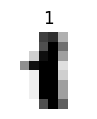

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.imshow(X[1].reshape(8,8), cmap='gray_r')
plt.axis('off')
plt.title(y[1])
plt.show()

In [31]:
from sklearn.svm import SVC
model = SVC(probability=True).fit(X, y)  # 기본 파라미터로 모형 생성

In [32]:
test_x = X[0].reshape(1,-1)
print('예측값:', model.predict(test_x), ',실제:',y[0])

예측값: [0] ,실제: 0


In [33]:
prob = model.predict_proba(test_x)[0]
classes = model.classes_
# print('분류:',classes)
# print('확률:',prob)
for c, p in zip(classes, prob):
    print("{}일 확률 : {:.3f}%".format(c,p*100))

0일 확률 : 99.096%
1일 확률 : 0.021%
2일 확률 : 0.050%
3일 확률 : 0.085%
4일 확률 : 0.065%
5일 확률 : 0.142%
6일 확률 : 0.075%
7일 확률 : 0.097%
8일 확률 : 0.075%
9일 확률 : 0.293%


In [34]:
# 파라미터 탐색 이전 score(accuracy)
model.score(X,y)

0.996661101836394

In [35]:
# SVC() 모형의 최적의 gamma값 탐색
# param_range = [0.000001, 0.000009, 0.00008, 0.0001, 0.005]
import numpy as np
param_range = np.logspace(-6, -1, 10)  # gamma값의 후보군 10의-6승 ~10의-1승
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [36]:
%%time
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(
                                SVC(),   # 예측모형, 판별함수
                                X, y,
                                param_name="gamma",  # gamma가 크면 결정경계가 복잡. overfitting위험
                                param_range=param_range,
                                cv=10,  # 교차검증
                                scoring="accuracy",  # balanced_accuracy(불균형을 고려한 정확도)
                                n_jobs=-1  # 내 시스템의 모든 코어를 사용해서 병렬처리
)

CPU times: total: 469 ms
Wall time: 11.6 s


In [37]:
test_scores.shape, train_scores.shape

((10, 10), (10, 10))

In [38]:
test_scores   #.shape, train_scores.shape

array([[0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.29608939, 0.19553073, 0.19553073],
       [0.67777778, 0.74444444, 0.7       , 0.66666667, 0.73333333,
        0.67222222, 0.72222222, 0.70949721, 0.67597765, 0.73743017],
       [0.87777778, 0.95      , 0.90555556, 0.86666667, 0.92222222,
        0.91666667, 0.96666667, 0.93854749, 0.83240223, 0.91061453],
       [0.92222222, 0.96666667, 0.95      , 0.91111111, 0.95      ,
        0.98333333, 0.97777778, 0.96648045, 0.87709497, 0.92178771],
       [0.93888889, 0.97222222, 0.93333333, 0.95      , 0.97222222,
        0.98888889, 0.98333333, 0.99441341, 0.91061453, 0.94413408],
       [0.95555556, 1.        , 0.93333333, 0.96666667, 0.98888889,
        0.98888889, 0.99444444, 0.99441341, 0.96089385, 0.96648045],
       [0.93333333, 0.98888889, 0.95555556, 0.96666667, 0.98333333,
        0.98888889, 0.99444444, 0.99441341, 0.97765363, 0.96648045],
       [0.77777778, 0.89444444, 0.7611111

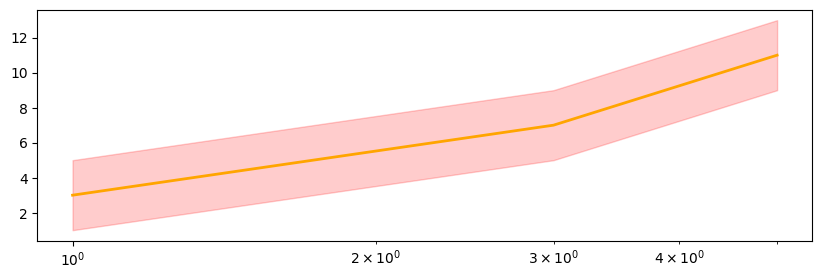

In [39]:
a = np.array([1,3,5])  # semilogx()적용하면 10의 1승, 10의 3승, 10의5승
b = np.array([3,7,11]) # 3,7,11
plt.figure(figsize=(10,3))
plt.semilogx(a,b, color='orange', lw=2)
plt.fill_between(a, b-2, b+2, color='red', alpha=0.2)

In [40]:
train_scores_mean = np.mean(train_scores, axis=1)  # train 평균
train_scores_std = np.std(train_scores, axis=1)  # train 표준편차
test_scores_mean = test_scores.mean(axis=1)  # test평균
test_scores_std = test_scores.std(axis=1)  # test표준편차

In [41]:
train_scores_mean

array([0.13836306, 0.72045751, 0.93439655, 0.96939318, 0.98775736,
       0.99789765, 1.        , 1.        , 1.        , 1.        ])

In [42]:
train_scores

array([[0.10204082, 0.10204082, 0.10204082, 0.10204082, 0.10204082,
        0.10204082, 0.10204082, 0.28615575, 0.19159456, 0.19159456],
       [0.71923315, 0.70995671, 0.72108844, 0.716141  , 0.71552257,
        0.71243043, 0.70810142, 0.72435105, 0.73918418, 0.73856613],
       [0.93753865, 0.93444651, 0.93320965, 0.93135436, 0.93692022,
        0.92888064, 0.93382808, 0.93201483, 0.94313968, 0.93263288],
       [0.96846011, 0.96969697, 0.96722325, 0.97217069, 0.96846011,
        0.96722325, 0.96846011, 0.96538937, 0.97342398, 0.97342398],
       [0.98824985, 0.98577613, 0.9894867 , 0.98763142, 0.98639456,
        0.98824985, 0.98824985, 0.98702101, 0.98825711, 0.98825711],
       [0.99814471, 0.99690785, 0.99814471, 0.99752628, 0.99690785,
        0.99814471, 0.99814471, 0.99814586, 0.99814586, 0.99876391],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.       

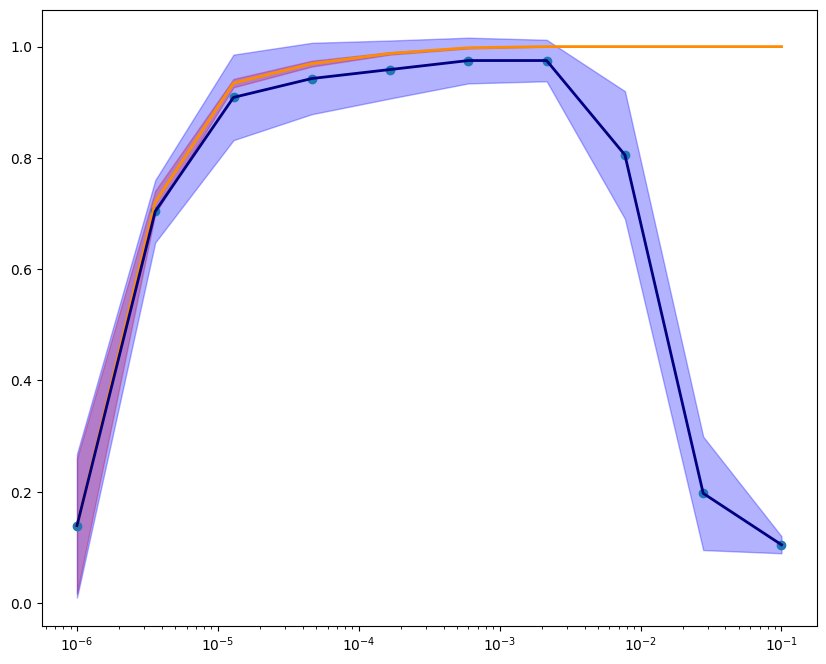

In [43]:
plt.figure(figsize=(10,8))
plt.semilogx(param_range, train_scores_mean, color='darkorange', lw=2)
plt.fill_between(param_range,
                train_scores_mean-train_scores_std*2,
                train_scores_mean+train_scores_std*2,
                alpha=0.3, color='red')
plt.semilogx(param_range, test_scores_mean, color='navy', lw=2)
plt.fill_between(param_range,
                test_scores_mean-test_scores_std*2,
                test_scores_mean+test_scores_std*2,
                alpha=0.3, color='blue')
plt.scatter(param_range, test_scores_mean)
plt.show()

In [44]:
test_scores_mean.argmax()

6

In [45]:
# 현재 모델에서 최적의 gamma
gamma = param_range[test_scores_mean.argmax()]
gamma

0.0021544346900318843

In [46]:
model = SVC(gamma=gamma).fit(X,y)

In [47]:
model.score(X,y)

1.0

## 2-2 GridSearchCV
- 복수 하이퍼파라미터 최적화 클래스
- 모형 클래스를 가지고 있음
- fit()/predict()/ score() / predict_proba() / predict_log_proba()

In [48]:
import pandas as pd
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine_X = redwine.iloc[:, :-1]
redwine_y = redwine.iloc[:, -1]
redwine_X.shape, redwine_y.shape

((1599, 11), (1599,))

In [49]:
# 가장 평가 점수가 높은 독립변수 ?개 선택, SVC()모형의 최적의 C=?, gamma=?, kernal=?
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC

In [50]:
%%time
# 가장 평가 점수가 높은 독립변수 ?개 선택, SVC()모형의 최적의 C=?
selection = SelectKBest(k=1)  # 가장 평가 점수가 높은 k개를 찾음
svc = SVC(kernel='linear')    # 직선으로 나누는 가장 단순한 decision_function
pipeline = Pipeline([('select',selection),('svc',svc)])
param_grid = dict(select__k = [5,6,7,8,9,10,11],
                  svc__C    = [0.1,1,10])   # 최적의 select__k와 svc__C의 조합을 찾는 것이 목적
grid_search = GridSearchCV(pipeline,
                           param_grid=param_grid, # 파라미터들
                           cv=2,   # 교차검증 횟수 k-fold cross validation
                           verbose=2,
                           n_jobs=-1
                          )
grid_search.fit(redwine_X, redwine_y)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
CPU times: total: 15.6 s
Wall time: 1min 45s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('select', SelectKBest(k=1)),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'select__k': [5, 6, 7, 8, 9, 10, 11],
                         'svc__C': [0.1, 1, 10]},
             verbose=2)

In [51]:
print(grid_search.best_estimator_)  # 가장 높은 점수를 낸 파라미터 모형

Pipeline(steps=[('select', SelectKBest(k=9)),
                ('svc', SVC(C=1, kernel='linear'))])


In [52]:
print(grid_search.best_params_)  # 최적의 파라미터 정보

{'select__k': 9, 'svc__C': 1}


In [53]:
model = grid_search.best_estimator_
model.predict(redwine_X)

array([5, 5, 5, ..., 6, 5, 6], dtype=int64)

In [54]:
# 최적의 k값과 C값의 model
model.score(redwine_X, redwine_y)

0.5872420262664165

In [55]:
# 기본 SVC model
model = SVC().fit(redwine_X, redwine_y)
model.score(redwine_X, redwine_y)

0.5103189493433395

# 3절. 자료 불균형 처리
- 단순 오버/언더 샘플링
- 단, 단순 오버샘플시 소스의 데이터를 복사하면 그 데이터들에 의해 과적합 생길 수 있음
- SMOTE 라이브러리를 이용한 오버샘플링

## 3-1 SMOTE를 이용한 오버샘플링

In [56]:
# 데이터 (99%:1%)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, #표본 데이터 수
                           n_features=10,   #독립변수 갯수
                           n_informative=5, #종속변수에 영향을 주는 갯수
                           n_redundant=0,   #독립변수들간 상관관계가 없다.
                           n_clusters_per_class=1,  #클래스당 서브 클러스터 수 
                           n_classes=2,
                           weights=[0.99, 0.01], # 각 클래스의 할당된 표본 확률
                           random_state=42)
X.shape, y.shape, y.sum() 

((10000, 10), (10000,), 140)

In [57]:
# train-test 셋 분리 => SMOTE(train데이터) => 모델 fit(train데이터) => score(test데이터)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 10), (3000, 10), (7000,), (3000,))

In [58]:
print(y_train.mean())  #7000개 중에 1이 1.4%
pd.Series(y_train).value_counts()

0.014


0    6902
1      98
dtype: int64

In [59]:
# SMOTE(train데이터)
# pip install imbalanced-learn==0.10.1
from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy={0:6902, 1:600})
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [60]:
pd.Series(y_resampled).value_counts()

0    6902
1    6902
dtype: int64

## 3-2 가중치 제어 모형
- 자료 불균형 처리의 또 다른 방법
- 모델에 데이터 따른 가중치 부여 방법

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight={0:1, 1:1.5},  # 0보다 1에1.5배 가중치 부여
                                  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.5}, random_state=42)

# 4절. 앙상블 모형
- 목적 : 여러개 분류 모델을 하나의 통합 분류모델로 연결하여 개별 분류모델보다 더 좋은 성능 달성
- 방법 : 
    * 배깅(bagging) : 분류를 잘하는 모델에 가중치(병렬작업) ex.RandomForest
    * 부스팅(boosting) : 분류가 안된 데이터에 가중치(순차작업) ex.XGBoost, LGBM, AdaBoost- 불균형데이터
    * 투표(Voting) : 여러개 모델의 다수결 투표    

cf. 배깅 알고리즘시 0.632규칙 :복원추출시 63.2% 추출됨 

In [62]:
np.random.choice(10, 10, replace=True)  # 복원추출로 10미만의 수를 10개 추출

array([3, 1, 3, 2, 5, 1, 8, 5, 8, 0])

In [63]:
# 10미만의 수 10개 복원추출할 경우 뽑히는 수의 갯수
len(set(np.random.choice(10, 10, replace=True) ))

6

In [64]:
# 1000미만의 수 1000개 복원추출할 경우 뽑히는 수의 갯수
len(set(np.random.choice(1000, 1000, replace=True) ))

630

In [65]:
# n미만의 수 n개 복원추출할 경우 뽑히는 데이터 퍼센트
n = 10000000
len(set(np.random.choice(n, n, replace=True)))/n

0.6321874

In [66]:
# 데이터
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000,
                          n_features=10,
                          n_informative=5,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          n_classes=2,
                          weights=[0.9,0.1],
                          random_state=42)

In [67]:
train_X, test_X, train_y, test_y = train_test_split(X,y,
                                                   test_size=0.3,
                                                   stratify=y,
                                                   random_state=42)
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(train_X, train_y)
resampled_X.shape, resampled_y.shape

((12556, 10), (12556,))

In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score

def model_measure(model, train_X= resampled_X, train_y=resampled_y,
                  test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    accuracy = model.score(test_X, test_y)
    hat_y = model.predict(test_X)
    precision = precision_score(test_y, hat_y)
    recall    = recall_score(test_y, hat_y)
    f1        = f1_score(test_y, hat_y)
    print(f"정확도:{accuracy:.4f}, precision:{precision:.4f}, recall:{recall:.4f}, f1:{f1:.4f}")

## 4-1 배깅(bagging)
- RandomForestClassifier, BaggingClassifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model_measure(model)

정확도:0.9830, precision:0.9418, recall:0.8900, f1:0.9151


In [70]:
from sklearn.ensemble import BaggingClassifier
model_measure(BaggingClassifier(n_estimators=100, bootstrap=True))  # 복원추출

정확도:0.9750, precision:0.8726, recall:0.8867, f1:0.8796


## 4-2 부스팅
- AdaBoost, XGB, LightGBM, CatBoost

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [72]:
model_measure(AdaBoostClassifier())

정확도:0.9570, precision:0.7368, recall:0.9061, f1:0.8128


In [73]:
model_measure(XGBClassifier())

정확도:0.9877, precision:0.9658, recall:0.9126, f1:0.9384


In [74]:
model_measure(LGBMClassifier(force_col_wise=True))

[LightGBM] [Info] Number of positive: 6278, number of negative: 6278
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 12556, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
정확도:0.9860, precision:0.9525, recall:0.9094, f1:0.9305


In [75]:
model_measure(CatBoostClassifier())

Learning rate set to 0.030349
0:	learn: 0.6530781	total: 149ms	remaining: 2m 29s
1:	learn: 0.6145178	total: 156ms	remaining: 1m 17s
2:	learn: 0.5766210	total: 164ms	remaining: 54.3s
3:	learn: 0.5415530	total: 171ms	remaining: 42.5s
4:	learn: 0.5130542	total: 178ms	remaining: 35.3s
5:	learn: 0.4837852	total: 184ms	remaining: 30.4s
6:	learn: 0.4564602	total: 190ms	remaining: 26.9s
7:	learn: 0.4313103	total: 197ms	remaining: 24.4s
8:	learn: 0.4116555	total: 203ms	remaining: 22.4s
9:	learn: 0.3939825	total: 209ms	remaining: 20.7s
10:	learn: 0.3766014	total: 215ms	remaining: 19.3s
11:	learn: 0.3586297	total: 221ms	remaining: 18.2s
12:	learn: 0.3439674	total: 227ms	remaining: 17.2s
13:	learn: 0.3291308	total: 233ms	remaining: 16.4s
14:	learn: 0.3159697	total: 239ms	remaining: 15.7s
15:	learn: 0.3033504	total: 245ms	remaining: 15.1s
16:	learn: 0.2903803	total: 251ms	remaining: 14.5s
17:	learn: 0.2776077	total: 257ms	remaining: 14s
18:	learn: 0.2689954	total: 264ms	remaining: 13.6s
19:	learn: 

168:	learn: 0.0670520	total: 1.19s	remaining: 5.84s
169:	learn: 0.0668083	total: 1.19s	remaining: 5.83s
170:	learn: 0.0666258	total: 1.2s	remaining: 5.82s
171:	learn: 0.0664644	total: 1.21s	remaining: 5.81s
172:	learn: 0.0662675	total: 1.21s	remaining: 5.79s
173:	learn: 0.0659853	total: 1.22s	remaining: 5.78s
174:	learn: 0.0657480	total: 1.22s	remaining: 5.77s
175:	learn: 0.0655198	total: 1.23s	remaining: 5.76s
176:	learn: 0.0652123	total: 1.24s	remaining: 5.75s
177:	learn: 0.0649938	total: 1.24s	remaining: 5.74s
178:	learn: 0.0647392	total: 1.25s	remaining: 5.73s
179:	learn: 0.0644812	total: 1.25s	remaining: 5.72s
180:	learn: 0.0642992	total: 1.26s	remaining: 5.71s
181:	learn: 0.0640149	total: 1.27s	remaining: 5.7s
182:	learn: 0.0637865	total: 1.27s	remaining: 5.68s
183:	learn: 0.0635182	total: 1.28s	remaining: 5.67s
184:	learn: 0.0632716	total: 1.28s	remaining: 5.66s
185:	learn: 0.0630627	total: 1.29s	remaining: 5.65s
186:	learn: 0.0627817	total: 1.3s	remaining: 5.64s
187:	learn: 0.0

333:	learn: 0.0387057	total: 2.2s	remaining: 4.38s
334:	learn: 0.0386175	total: 2.21s	remaining: 4.38s
335:	learn: 0.0384496	total: 2.21s	remaining: 4.38s
336:	learn: 0.0383803	total: 2.22s	remaining: 4.37s
337:	learn: 0.0382527	total: 2.23s	remaining: 4.37s
338:	learn: 0.0381580	total: 2.24s	remaining: 4.36s
339:	learn: 0.0380509	total: 2.24s	remaining: 4.35s
340:	learn: 0.0379351	total: 2.25s	remaining: 4.35s
341:	learn: 0.0378487	total: 2.25s	remaining: 4.34s
342:	learn: 0.0377270	total: 2.26s	remaining: 4.33s
343:	learn: 0.0376340	total: 2.27s	remaining: 4.33s
344:	learn: 0.0374985	total: 2.27s	remaining: 4.32s
345:	learn: 0.0373873	total: 2.28s	remaining: 4.32s
346:	learn: 0.0373189	total: 2.29s	remaining: 4.31s
347:	learn: 0.0372295	total: 2.3s	remaining: 4.3s
348:	learn: 0.0371573	total: 2.3s	remaining: 4.29s
349:	learn: 0.0371008	total: 2.31s	remaining: 4.29s
350:	learn: 0.0369810	total: 2.31s	remaining: 4.28s
351:	learn: 0.0368576	total: 2.32s	remaining: 4.28s
352:	learn: 0.03

498:	learn: 0.0248155	total: 3.23s	remaining: 3.25s
499:	learn: 0.0247682	total: 3.24s	remaining: 3.24s
500:	learn: 0.0247166	total: 3.25s	remaining: 3.23s
501:	learn: 0.0246410	total: 3.25s	remaining: 3.23s
502:	learn: 0.0245928	total: 3.26s	remaining: 3.22s
503:	learn: 0.0245269	total: 3.27s	remaining: 3.22s
504:	learn: 0.0244489	total: 3.27s	remaining: 3.21s
505:	learn: 0.0243988	total: 3.28s	remaining: 3.2s
506:	learn: 0.0243584	total: 3.29s	remaining: 3.19s
507:	learn: 0.0242892	total: 3.29s	remaining: 3.19s
508:	learn: 0.0242586	total: 3.3s	remaining: 3.18s
509:	learn: 0.0242455	total: 3.3s	remaining: 3.17s
510:	learn: 0.0242051	total: 3.31s	remaining: 3.17s
511:	learn: 0.0241816	total: 3.31s	remaining: 3.16s
512:	learn: 0.0241439	total: 3.32s	remaining: 3.15s
513:	learn: 0.0240695	total: 3.33s	remaining: 3.15s
514:	learn: 0.0239839	total: 3.33s	remaining: 3.14s
515:	learn: 0.0239230	total: 3.34s	remaining: 3.13s
516:	learn: 0.0238923	total: 3.35s	remaining: 3.13s
517:	learn: 0.0

669:	learn: 0.0166284	total: 4.27s	remaining: 2.1s
670:	learn: 0.0165972	total: 4.28s	remaining: 2.1s
671:	learn: 0.0165732	total: 4.28s	remaining: 2.09s
672:	learn: 0.0165391	total: 4.29s	remaining: 2.08s
673:	learn: 0.0165116	total: 4.29s	remaining: 2.08s
674:	learn: 0.0164718	total: 4.3s	remaining: 2.07s
675:	learn: 0.0164141	total: 4.31s	remaining: 2.06s
676:	learn: 0.0163653	total: 4.31s	remaining: 2.06s
677:	learn: 0.0163318	total: 4.32s	remaining: 2.05s
678:	learn: 0.0163110	total: 4.33s	remaining: 2.04s
679:	learn: 0.0162711	total: 4.33s	remaining: 2.04s
680:	learn: 0.0162329	total: 4.34s	remaining: 2.03s
681:	learn: 0.0162178	total: 4.34s	remaining: 2.02s
682:	learn: 0.0162031	total: 4.35s	remaining: 2.02s
683:	learn: 0.0161581	total: 4.36s	remaining: 2.01s
684:	learn: 0.0161219	total: 4.36s	remaining: 2.01s
685:	learn: 0.0161071	total: 4.37s	remaining: 2s
686:	learn: 0.0160900	total: 4.37s	remaining: 1.99s
687:	learn: 0.0160686	total: 4.38s	remaining: 1.99s
688:	learn: 0.0160

840:	learn: 0.0118076	total: 5.31s	remaining: 1s
841:	learn: 0.0117809	total: 5.32s	remaining: 998ms
842:	learn: 0.0117691	total: 5.32s	remaining: 991ms
843:	learn: 0.0117459	total: 5.33s	remaining: 985ms
844:	learn: 0.0117321	total: 5.33s	remaining: 979ms
845:	learn: 0.0117060	total: 5.34s	remaining: 972ms
846:	learn: 0.0116871	total: 5.35s	remaining: 966ms
847:	learn: 0.0116754	total: 5.35s	remaining: 959ms
848:	learn: 0.0116185	total: 5.36s	remaining: 953ms
849:	learn: 0.0115860	total: 5.37s	remaining: 947ms
850:	learn: 0.0115674	total: 5.37s	remaining: 940ms
851:	learn: 0.0115434	total: 5.38s	remaining: 934ms
852:	learn: 0.0115247	total: 5.38s	remaining: 928ms
853:	learn: 0.0115057	total: 5.39s	remaining: 921ms
854:	learn: 0.0114946	total: 5.39s	remaining: 915ms
855:	learn: 0.0114623	total: 5.4s	remaining: 909ms
856:	learn: 0.0114498	total: 5.41s	remaining: 902ms
857:	learn: 0.0114236	total: 5.41s	remaining: 896ms
858:	learn: 0.0114027	total: 5.42s	remaining: 890ms
859:	learn: 0.01

정확도:0.9883, precision:0.9628, recall:0.9223, f1:0.9421


## 4-3 투표를 이용한 앙상블(61p)
- voting = 'hard' : 다수결로 투표
- voting = 'soft' : 확률의 합을 계산하여 투표(64page)

In [2]:
# 데이터
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000,
                          n_features=10,
                          n_informative=5,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          n_classes=2,
                          random_state=42)
X.shape, y.shape

((10000, 10), (10000,))

In [6]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y,test_y = train_test_split(X,y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((7000, 10), (3000, 10), (7000,), (3000,))

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

def model_measure(model, train_X= train_X, train_y=train_y,
                  test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    accuracy = model.score(test_X, test_y)
    hat_y = model.predict(test_X)
    precision = precision_score(test_y, hat_y)
    recall    = recall_score(test_y, hat_y)
    f1        = f1_score(test_y, hat_y)
    print(f"정확도:{accuracy:.4f}, precision:{precision:.4f}, recall:{recall:.4f}, f1:{f1:.4f}")

In [ ]:
# pip install xgboost==1.7.3
# pip install lightgbm                        # 4.6.0

In [9]:
%%time
from sklearn.ensemble import RandomForestClassifier  # 배깅
from xgboost import XGBClassifier    # 부스터
from lightgbm import LGBMClassifier  # 부스터 
# max_features=2 : 결정트리의 각 분기 노드에서 전체 독립변수중 무작위 2개의 특성만 고려하여 T/F로 분기
rf_model = RandomForestClassifier(max_features=2,  # 노드하나마다 독립변수 몇개 넣을건지
                                  random_state=42)
xgb_model = XGBClassifier(max_depth=10,         # 트리의 최대 깊이
                         n_estimators=100,      # 트리 갯수
                         learning_rate=0.01,
                         eval_metric='logloss')
lgb_model = LGBMClassifier(verbose=-1)  # 로그 출력 없이
model_measure(rf_model)
model_measure(xgb_model)
model_measure(lgb_model)

정확도:0.9693, precision:0.9757, recall:0.9627, f1:0.9691
정확도:0.9617, precision:0.9607, recall:0.9627, f1:0.9617
정확도:0.9770, precision:0.9831, recall:0.9707, f1:0.9769
CPU times: total: 7.56 s
Wall time: 5.72 s


In [10]:
%%time
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(estimators=[('rfm', rf_model),
                                            ('xgb', xgb_model),
                                            ('lgb',lgb_model)],
                                voting='hard')  # 다수결
voting_model.fit(train_X, train_y)                            

CPU times: total: 6.56 s
Wall time: 2.29 s


VotingClassifier(estimators=[('rfm',
                              RandomForestClassifier(max_features=2,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_polic...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lgb', LGBMClassifier(verbose=-1))])

In [11]:
voting_model.named_estimators_

{'rfm': RandomForestClassifier(max_features=2, random_state=42),
 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.01, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None, ...),
 'lgb': LGBMClassifier(verbose=-1)}

In [12]:
%%time
model_measure(voting_model.named_estimators_['rfm'])
model_measure(voting_model.named_estimators_['xgb'])
model_measure(voting_model.named_estimators_['lgb'])
model_measure(voting_model)

정확도:0.9693, precision:0.9757, recall:0.9627, f1:0.9691
정확도:0.9617, precision:0.9607, recall:0.9627, f1:0.9617
정확도:0.9770, precision:0.9831, recall:0.9707, f1:0.9769
정확도:0.9737, precision:0.9785, recall:0.9687, f1:0.9735
CPU times: total: 14.3 s
Wall time: 5.03 s


In [13]:
%%time
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(estimators=[('rfm', rf_model),
                                            ('xgb', xgb_model),
                                            ('lgb',lgb_model)],
                                voting='soft')  # 확률의 합이 높은 쪽으로
voting_model.fit(train_X, train_y) 

CPU times: total: 6.67 s
Wall time: 2.44 s


VotingClassifier(estimators=[('rfm',
                              RandomForestClassifier(max_features=2,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_polic...
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lgb', LGBMClassifier(verbose=-1))],
                 voting='soft')

In [14]:
%%time
model_measure(voting_model.named_estimators_['rfm'])
model_measure(voting_model.named_estimators_['xgb'])
model_measure(voting_model.named_estimators_['lgb'])
model_measure(voting_model)

정확도:0.9693, precision:0.9757, recall:0.9627, f1:0.9691
정확도:0.9617, precision:0.9607, recall:0.9627, f1:0.9617
정확도:0.9770, precision:0.9831, recall:0.9707, f1:0.9769
정확도:0.9760, precision:0.9824, recall:0.9693, f1:0.9758
CPU times: total: 14.3 s
Wall time: 4.91 s
